# Proyecto de prácticas - Modelo predictivo del comportamiento de matrículas para la optimización de la oferta académica de una Universidad.

## Juan David Padilla Páez - 200145173

# Importación de Base de Datos

## Librerías

### Procesamiento de datos

In [24]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

### Graficos

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

### Rutas de los archivos

In [67]:
import routes
import warnings
warnings.filterwarnings('ignore')

## Creación de dataframes

### Importación de los datos crudos

In [4]:
# Se cargan los archivos de excel
dfAdmitidos = pd.read_excel(routes.path_admitidos)
dfMatprimer = pd.read_excel(routes.path_matprimer)
dfInscritos = pd.read_excel(routes.path_inscritos, sheet_name='Inscritos')

In [5]:
# Se normaliza el nombre de las columnas
dfInscritos.columns = [col.replace('\n', ' ') for col in dfInscritos.columns]
dfInscritos.columns = dfInscritos.columns.str.upper()

### Agregación de Género

#### Admitidos

In [6]:
group_columns = [
    'CÓDIGO DE LA INSTITUCIÓN', 'IES PADRE',
    'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)', 'PRINCIPAL O SECCIONAL',
    'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL DEPARTAMENTO (IES)',
    'DEPARTAMENTO DE DOMICILIO DE LA IES', 'CÓDIGO DEL MUNICIPIO IES',
    'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO SNIES DEL PROGRAMA',
    'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
    'METODOLOGÍA', 'CÓDIGO DEL DEPARTAMENTO (PROGRAMA)',
    'DEPARTAMENTO DE OFERTA DEL PROGRAMA', 'CÓDIGO DEL MUNICIPIO (PROGRAMA)',
    'MUNICIPIO DE OFERTA DEL PROGRAMA', 'AÑO', 'SEMESTRE'   # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'ADMITIDOS'
aggregated_dfAdmitidos = dfAdmitidos.groupby(group_columns, as_index=False)['ADMITIDOS'].sum()


#### Primer Curso

In [7]:
group_columns = [
    'CÓDIGO DE LA INSTITUCIÓN', 'IES_PADRE',
    'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)', 'PRINCIPAL O SECCIONAL',
    'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL DEPARTAMENTO (IES)',
    'DEPARTAMENTO DE DOMICILIO DE LA IES', 'CÓDIGO DEL MUNICIPIO (IES)',
    'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO SNIES DEL PROGRAMA',
    'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
    'METODOLOGÍA', 'CÓDIGO DEL DEPARTAMENTO (PROGRAMA)',
    'DEPARTAMENTO DE OFERTA DEL PROGRAMA', 'CÓDIGO DEL MUNICIPIO (PROGRAMA)',
    'MUNICIPIO DE OFERTA DEL PROGRAMA', 'AÑO', 'SEMESTRE'   # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'PRIMER CURSO'
aggregated_dfMatprimer = dfMatprimer.groupby(group_columns, as_index=False)['PRIMER CURSO'].sum()

#### Inscritos

In [8]:
group_columns = [
    'CÓDIGO DE  LA INSTITUCIÓN', 'IES PADRE',
       'INSTITUCIÓN DE EDUCACIÓN SUPERIOR', 'PRINCIPAL  O  SECCIONAL',
       'SECTOR IES', 'CARACTER IES', 'CÓDIGO DEL  DEPARTAMENTO (IES)',
       'DEPARTAMENTO DE  DOMICILIO DE LA IES', 'CÓDIGO DEL  MUNICIPIO (IES)',
       'MUNICIPIO DE DOMICILIO DE LA IES', 'CÓDIGO  SNIES DEL PROGRAMA',
       'PROGRAMA ACADÉMICO', 'NIVEL ACADÉMICO', 'NIVEL DE FORMACIÓN',
       'METODOLOGÍA', 'CÓDIGO DEL  DEPARTAMENTO (PROGRAMA)',
       'DEPARTAMENTO DE OFERTA DEL PROGRAMA',
       'CÓDIGO DEL  MUNICIPIO (PROGRAMA)', 'SEMESTRE' ,'MUNICIPIO DE OFERTA DEL PROGRAMA',
       'AÑO'  # Include AÑO to aggregate per year
]

# Group by the defined columns and sum the 'ADMITIDOS'
aggregated_dfInscritos = dfInscritos.groupby(group_columns, as_index=False)['INSCRITOS'].sum()

### Preparación del dataframe

In [14]:
aggregated_dfMatprimer['AÑO'] = pd.to_datetime(aggregated_dfMatprimer['AÑO'], format='%Y')
aggregated_dfMatprimer['DATE'] = aggregated_dfMatprimer.apply(
    lambda row: row['AÑO'] + pd.DateOffset(months=6*(row['SEMESTRE']-1)),
    axis=1
)
aggregated_dfMatprimer['INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)']

0                     UNIVERSIDAD NACIONAL DE COLOMBIA
1                     UNIVERSIDAD NACIONAL DE COLOMBIA
2                     UNIVERSIDAD NACIONAL DE COLOMBIA
3                     UNIVERSIDAD NACIONAL DE COLOMBIA
4                     UNIVERSIDAD NACIONAL DE COLOMBIA
                              ...                     
212255    CORPORACIÓN UNIVERSITARIA AUTÓNOMA DEL NORTE
212256    CORPORACIÓN UNIVERSITARIA AUTÓNOMA DEL NORTE
212257    CORPORACIÓN UNIVERSITARIA AUTÓNOMA DEL NORTE
212258    CORPORACIÓN UNIVERSITARIA AUTÓNOMA DEL NORTE
212259    CORPORACIÓN UNIVERSITARIA AUTÓNOMA DEL NORTE
Name: INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES), Length: 212260, dtype: object

In [15]:
# Aggregate the 'PRIMER CURSO' per year and program
program_df = aggregated_dfMatprimer.groupby(['DATE', 'PROGRAMA ACADÉMICO', 'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)']).agg({'PRIMER CURSO': 'sum'}).reset_index()


# Creación de modelos

## Modelo Prophet

In [68]:
# Assuming `aggregated_dfMatprimer` is already loaded with appropriate data
# Aggregate the 'PRIMER CURSO' per year and program
program_df = aggregated_dfMatprimer.groupby(['DATE', 'PROGRAMA ACADÉMICO', 'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)']).agg({'PRIMER CURSO': 'sum'}).reset_index()

# Specify the program you want to forecast
target_program = "ADMINISTRACION FINANCIERA"

# Filter data for the specific program
specific_program_data = program_df[program_df['PROGRAMA ACADÉMICO'] == target_program]

# Convert 'INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)' to one-hot encoding
one_hot_institutions = pd.get_dummies(specific_program_data['INSTITUCIÓN DE EDUCACIÓN SUPERIOR (IES)'])
specific_program_data = pd.concat([specific_program_data, one_hot_institutions], axis=1)

# Initialize the Prophet model with additional regressors for each institution
model = Prophet()

# Add institution one-hot encoding as additional regressors
for column in one_hot_institutions.columns:
    model.add_regressor(column)

# Prepare the data for Prophet
specific_program_data['ds'] = specific_program_data['DATE']
specific_program_data['y'] = specific_program_data['PRIMER CURSO']

# Create and fit the Prophet model using all the data and institution regressors
model.fit(specific_program_data[['ds', 'y'] + list(one_hot_institutions.columns)])

# Make future predictions
future = model.make_future_dataframe(periods=4, freq='6M')

# Identify the last historical date in the original dataset
last_hist_date = specific_program_data['ds'].max()

# Adjust only the future prediction dates to start at the beginning of a month
future.loc[future['ds'] > last_hist_date, 'ds'] = future['ds'][future['ds'] > last_hist_date] + pd.offsets.MonthBegin(-1)

# Carry over the one-hot encoding for institutions to the future DataFrame
for column in one_hot_institutions.columns:
    future[column] = 0  # or appropriate values based on expected future conditions

# Predict
forecast = model.predict(future)

# Perform cross-validation
df_cv = cross_validation(model, initial='1460 days', period='182 days', horizon='730 days')

# Calculate the performance metrics
df_p = performance_metrics(df_cv)

# Show the performance metrics
print(df_p)

# Display the first few rows of the forecast results
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plotting with Plotly
trace1 = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prediction')
trace2 = go.Scatter(x=specific_program_data['ds'], y=specific_program_data['y'], mode='lines+markers', name='Actual Data')
layout = go.Layout(title='Academic Program Demand Forecast', xaxis_title='Date', yaxis_title='Quantity')
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing


    horizon           mse        rmse         mae      mape     mdape  \
0  181 days   2478.646483   49.786007   33.961763  1.183152  0.279344   
1  182 days   2505.990247   50.059867   38.658282  1.713079  0.673072   
2  184 days  25071.745546  158.340600   97.939397  4.042796  1.232754   
3  362 days  32824.850309  181.176296  128.682762  5.357252  1.435220   
4  363 days  26665.431614  163.295535  118.528182  3.969686  1.022444   
5  364 days  22817.699653  151.055287  116.137681  4.915322  1.084807   
6  365 days  35826.410561  189.278658  139.817923  7.456229  1.478268   
7  366 days  45980.240536  214.430036  163.189212  7.147467  2.171512   
8  544 days  37079.354223  192.560002  151.372087  5.396639  2.064637   
9  546 days  26240.258619  161.988452  129.910428  5.954580  1.862368   
10 547 days  36905.598575  192.108299  141.893932  8.066329  1.673859   
11 548 days  47438.785458  217.804466  158.019349  8.442798  1.790406   
12 549 days  44883.957875  211.858344  160.996125  

Con el modelo de Prophet, se puede ver el comportamiento de los datos a través del tiempo, y se puede predecir con un grado de confiabilidad normal a bajo dependiendo del programa y los datos que hay respecto a este.

## Holts-Winters

In [69]:
# Fit model
model = ExponentialSmoothing(specific_program_data['y'], trend="add", seasonal="add", seasonal_periods=2)
model_fit = model.fit()

# Forecast next few periods
forecast = model_fit.forecast(steps=4)
print(forecast)

205    82.855943
206    81.945662
207    77.187543
208    76.277262
dtype: float64


In [75]:
n_splits = 3  # for simplicity, assuming we want 3 validation points

# Initialize lists to store the performance of each fold
mse_scores = []
mae_scores = []

# The minimum number of observations we decide is needed to start forecasting
min_train_size = 6

for t in range(min_train_size, len(specific_program_data) - n_splits + 1):
    train = specific_program_data.iloc[:t]
    test = specific_program_data.iloc[t:t+n_splits]  # here n_splits is 1 for one-step ahead prediction
    
    # Fit model
    model = ExponentialSmoothing(specific_program_data['y'], seasonal='add', seasonal_periods=4)
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=n_splits)
    
    # Calculate performance metrics
    mse = mean_squared_error(test['y'], forecast)
    mae = mean_absolute_error(test['y'], forecast)
    
    # Store the scores
    mse_scores.append(mse)
    mae_scores.append(mae)

# Print average scores
print('')
print('')
print(' -- Exponential Smoothing --')
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Average MAE: {np.mean(mae_scores)}')
print('')
print('')




 -- Exponential Smoothing --
Average MSE: 24682.83246420753
Average MAE: 115.13982977179487




De acuerdo a los resultados y las métricas obtenidas, las predicciones no cuentan con una confiabilidad suficiente

## Regresión Lineal

In [71]:
# Correlación lineal entre las dos variables
# ==============================================================================

specific_program_data['ds_numeric'] = (specific_program_data['ds'] - specific_program_data['ds'].min()).dt.days

corr_test = pearsonr(x = specific_program_data['ds_numeric'], y = specific_program_data['y'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  -0.04829594778613413
P-value:  0.4916632198705478


Como se puede apreciar, los valores indican que no existe una correlación entre los datos, por lo que no resultará provechoso realizar un modelo de regresión lineal con los datos.

## ARIMA

In [72]:
data = []
for y in specific_program_data['y']:
    data.append(y)


series = pd.Series(data=data, index=specific_program_data['ds'])

train_size = int(len(series) * 0.7)  # 80% of data for training
train, test = series[:train_size], series[train_size:]


ADF Statistic: -14.191650
p-value: 0.000000
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -907.821
Date:                Thu, 02 May 2024   AIC                           1821.642
Time:                        18:09:48   BIC                           1830.510
Sample:                             0   HQIC                          1825.246
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1450      0.113     -1.280      0.200      -0.367       0.077
ma.L1         -0.9986      0.443     -2.256      0.024      -1.866      -0.131
sigma2  

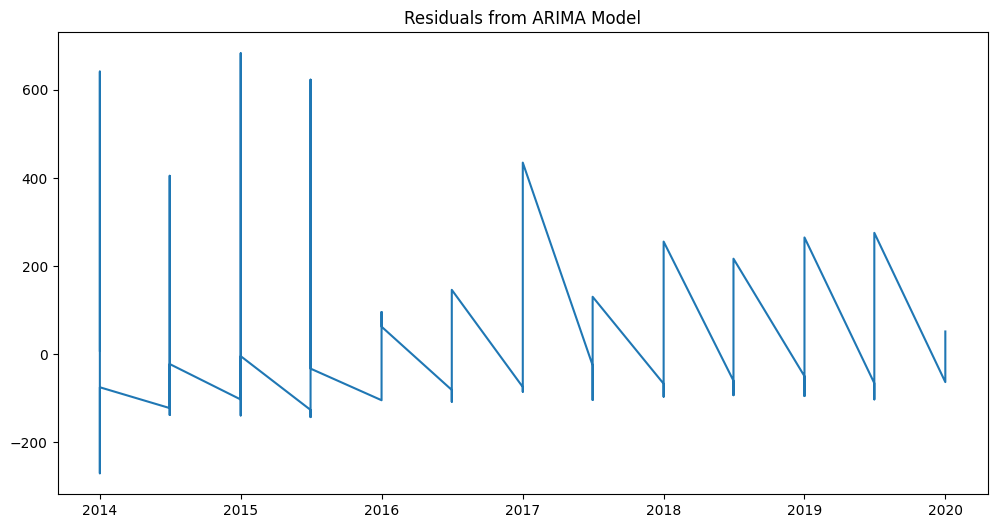

In [73]:
# Testing for stationarity
result = sm.tsa.adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Fit the ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))

# Check for residuals
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

MSE: 24917.256443760427, RMSE: 157.85200804475193, MAE: 110.17650131661836


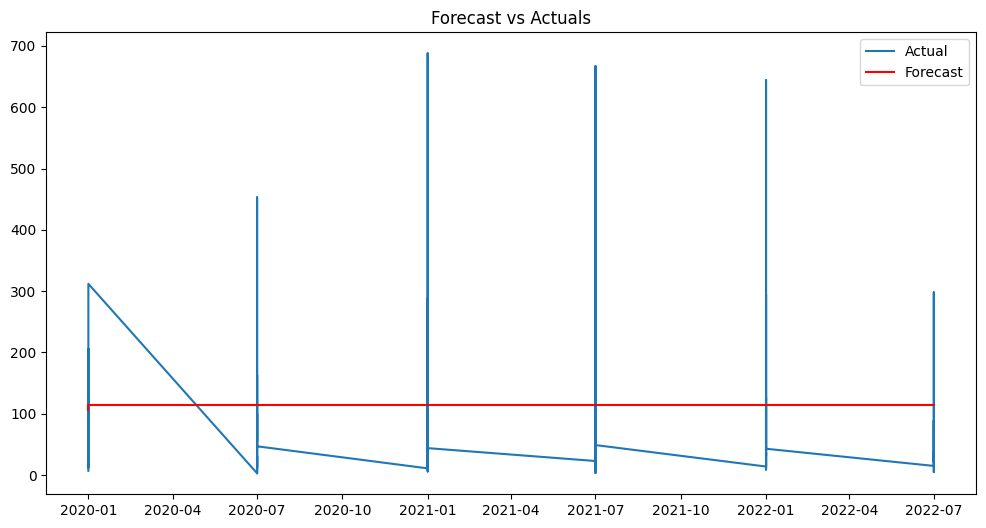

In [74]:
# Calculate errors
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()